In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/project/tomatoAll.zip /content
!unzip /content/tomatoAll.zip

Streaming output truncated to the last 5000 lines.
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25592188-309d-450c-b45f-fbbdb02b316f___Matt.S_CG 6181.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/2567c820-aa63-490c-8e47-921b85164728___Matt.S_CG 7447.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/256b92d9-41f3-47a4-870f-c0c0f0ac201e___Matt.S_CG 6842.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25b6cc2a-d883-4e3f-9caa-738e5ec35e30___JR_Sept.L.S 8465.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25c45a05-4f45-42ad-b18a-b7f694023a31___Matt.S_CG 0824.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25f7a39f-7fef-4f5d-af4f-cf21934f516a___JR_Sept.L.S 2493.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/261666dc-32fb-43b2-93

In [ ]:
!ls tomatoAll

plan-diseases-expert  plant-village


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/tomatoAll/'
expert_path = '/content/tomatoAll/plan-diseases-expert'
village_path = '/content/tomatoAll/plant-village'


BATCH_SIZE = 128
IMG_SIZE = (256, 256)
SEED = 42

In [3]:
train_gen, test_gen = tf.keras.utils.image_dataset_from_directory(
    expert_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


VALIDATION_SPLIT = 0.15

train_gen = train_gen.take(int((1 - VALIDATION_SPLIT) * len(train_gen)))
valid_gen = train_gen.skip(int((1 - VALIDATION_SPLIT) * len(train_gen)))

test2_gen = tf.keras.utils.image_dataset_from_directory(
    village_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test2_gen = test2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 37455 files belonging to 9 classes.
Using 31837 files for training.
Using 5618 files for validation.
Found 12803 files belonging to 9 classes.


In [4]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
import time
import matplotlib.pyplot as plt

In [6]:
def create_and_train_model(base_model, train_gen, test_gen, model_filename, freeze_layers=True):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Modify pre-trained model
    output = Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=50)

    # Save the model
    model.save(model_filename)

    # Plotting Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Measure inference time 2
    start_time = time.time()
    _, accuracy2 = model.evaluate(test2_gen)
    end_time = time.time()
    inference_time2 = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    return num_params, inference_time, accuracy, inference_time2, accuracy2


Epoch 1/50
13/13 [==============================] - 61s 1s/step - loss: 0.8157 - accuracy: 0.7252 - val_loss: 2.0497 - val_accuracy: 0.3813
Epoch 2/50
13/13 [==============================] - 9s 725ms/step - loss: 0.0972 - accuracy: 0.9663 - val_loss: 2.0001 - val_accuracy: 0.4114
Epoch 3/50
13/13 [==============================] - 9s 728ms/step - loss: 0.0235 - accuracy: 0.9925 - val_loss: 1.3718 - val_accuracy: 0.6001
Epoch 4/50
13/13 [==============================] - 9s 731ms/step - loss: 0.0078 - accuracy: 0.9982 - val_loss: 1.2083 - val_accuracy: 0.6897
Epoch 5/50
13/13 [==============================] - 9s 729ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 1.0800 - val_accuracy: 0.7556
Epoch 6/50
13/13 [==============================] - 9s 729ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.9180 - val_accuracy: 0.7969
Epoch 7/50
13/13 [==============================] - 9s 730ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.8116 - val_accuracy: 0.8350
Epoch 8/

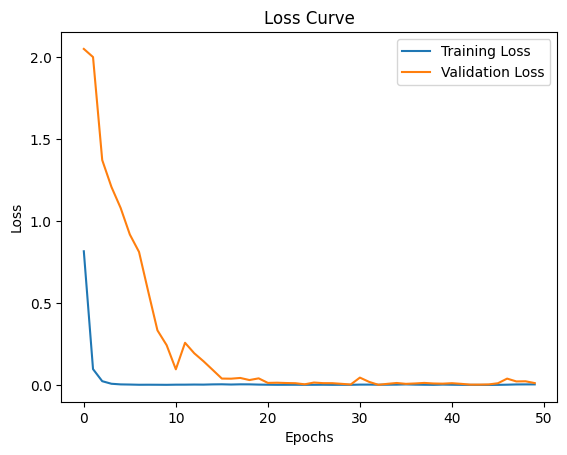

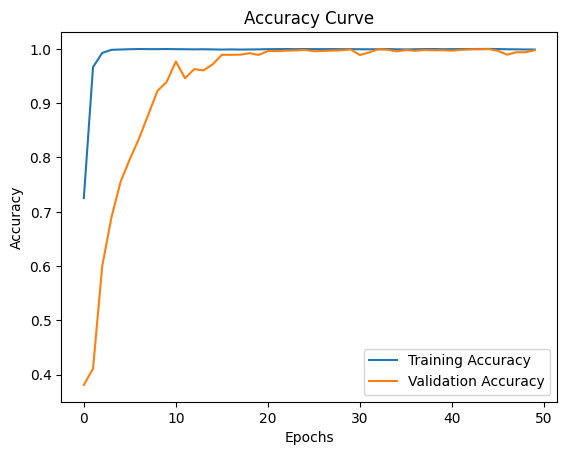

7/7 [==============================] - 7s 140ms/step - loss: 0.0287 - accuracy: 0.9930
EfficientNetB1: Params=6586768, Time=2.364053249359131, Accuracy=0.987540066242218, Time2=6.569878339767456, Accuracy2=0.9929704070091248


In [ ]:
# Create and train EfficientNetB1 75 2048
effnet_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
effnet_params, effnet_time, effnet_acc, effnet_time2, effnet_acc2 = create_and_train_model(effnet_base, train_gen, test_gen, freeze_layers = False)
print(f"EfficientNetB1: Params={effnet_params}, Time={effnet_time}, Accuracy={effnet_acc}, Time2={effnet_time2}, Accuracy2={effnet_acc2}")

Epoch 1/50
211/211 [==============================] - 152s 494ms/step - loss: 0.1270 - accuracy: 0.9591 - val_loss: 0.0785 - val_accuracy: 0.9797
Epoch 2/50
211/211 [==============================] - 98s 466ms/step - loss: 0.0250 - accuracy: 0.9925 - val_loss: 0.1400 - val_accuracy: 0.9575
Epoch 3/50
211/211 [==============================] - 98s 466ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.0255 - val_accuracy: 0.9927
Epoch 4/50
211/211 [==============================] - 98s 465ms/step - loss: 0.0122 - accuracy: 0.9967 - val_loss: 0.0243 - val_accuracy: 0.9934
Epoch 5/50
211/211 [==============================] - 98s 465ms/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0350 - val_accuracy: 0.9895
Epoch 6/50
211/211 [==============================] - 98s 465ms/step - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.0592 - val_accuracy: 0.9858
Epoch 7/50
211/211 [==============================] - 98s 465ms/step - loss: 0.0120 - accuracy: 0.9960 - val_loss: 0.0059 - val_a

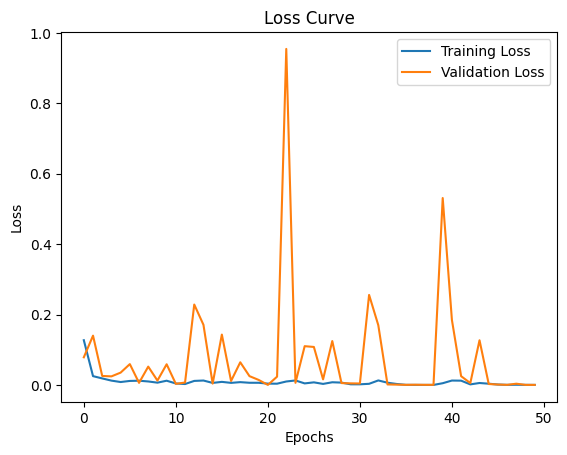

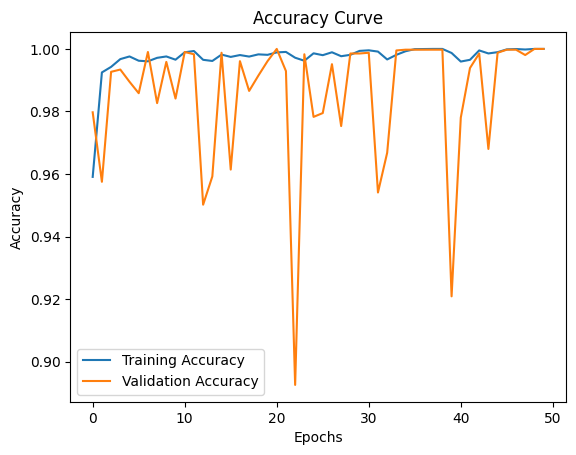

101/101 [==============================] - 11s 108ms/step - loss: 0.0013 - accuracy: 0.9997
EfficientNetB1: Params=6586768, Time=4.8985466957092285, Accuracy=0.9996439814567566, Time2=11.04729700088501, Accuracy2=0.9996875524520874


In [ ]:
# Create and train EfficientNetB1 256 128
effnet_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
effnet_params, effnet_time, effnet_acc, effnet_time2, effnet_acc2 = create_and_train_model(effnet_base, train_gen, test_gen, freeze_layers = False)
print(f"EfficientNetB1: Params={effnet_params}, Time={effnet_time}, Accuracy={effnet_acc}, Time2={effnet_time2}, Accuracy2={effnet_acc2}")

Epoch 1/50
211/211 [==============================] - 167s 498ms/step - loss: 0.1283 - accuracy: 0.9599 - val_loss: 1.3280 - val_accuracy: 0.7617
Epoch 2/50
211/211 [==============================] - 99s 471ms/step - loss: 0.0224 - accuracy: 0.9933 - val_loss: 0.0078 - val_accuracy: 0.9976
Epoch 3/50
211/211 [==============================] - 100s 472ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.0377 - val_accuracy: 0.9880
Epoch 4/50
211/211 [==============================] - 99s 471ms/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 0.0409 - val_accuracy: 0.9917
Epoch 5/50
211/211 [==============================] - 99s 470ms/step - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.0509 - val_accuracy: 0.9846
Epoch 6/50
211/211 [==============================] - 99s 469ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.0213 - val_accuracy: 0.9927
Epoch 7/50
211/211 [==============================] - 99s 469ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0105 - val_

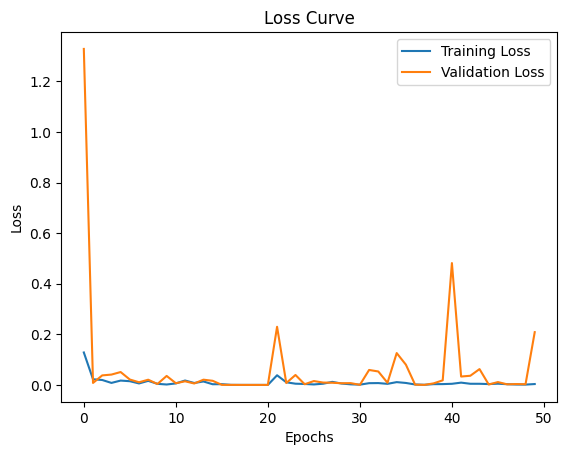

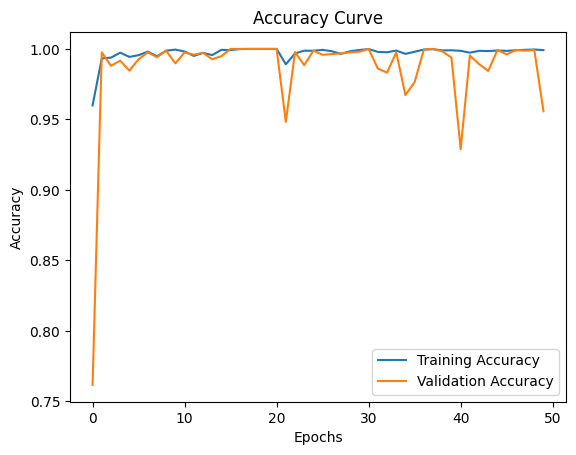

101/101 [==============================] - 11s 112ms/step - loss: 0.2067 - accuracy: 0.9581
EfficientNetB1: Params=6586768, Time=4.8973917961120605, Accuracy=0.9466001987457275, Time2=11.486617803573608, Accuracy2=0.9581348299980164


In [7]:
# Create and train EfficientNetB1 256 128
effnet_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
effnet_params, effnet_time, effnet_acc, effnet_time2, effnet_acc2 = create_and_train_model(effnet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/effnetB1_tomatoAll_256s_128b_50e_ntrainable.model', freeze_layers = False)
print(f"EfficientNetB1: Params={effnet_params}, Time={effnet_time}, Accuracy={effnet_acc}, Time2={effnet_time2}, Accuracy2={effnet_acc2}")